# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

class Node:
    # parent class of other nodes
    def __init__(self, inputs=[]):
        # inputs and outputs at every node
        self.inputs = inputs
        self.outputs = []
        
        # every node is the output of its input
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes
            
        self.value = None
        
        self.gradients = {}
        # keys are inputs to this node
        # their values are the partials of this node with respect to that input
        # \partial{node}{input_i}
        
    def forward(self):
        # forward propagation, other classes will inherit and overwrite this method
        """
        Forward propagation
        Compute the output value based on 'inbound_nodes' and store
        the result in self.value
        """
        raise NotImplemented
        
    def backward(self):
        # backward propagation, other classes will inherit and overwrite this method
        raise NotImplemented
        
class Input(Node):
    # input node, includes input node, weighted node, bias node of neural network
    def __init__(self):
        """
        An input node has no inbound nodes
        No need to pass anything to the Node instantiator
        """
        Node.__init__(self)
    
    def forward(self, value=None):
        """
        Only input node is the node where the value may be passed
        as an argument to forward()
        All other node implementations should get the value of hte previous node
        from self.inbound_nodes

        Example:
        val0: self.inbound_nodes[0].value
        """
        # set node value
        if value is not None:
            self.value = value
            # If it is input node, when need to forward, this node initiate self's value
        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
    
    def backward(self):
        # calculate node's gradient
        self.gradients = {self:0} # initialisation
        for n in self.outputs:
            # the output node's gradient towards this node
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        # input N --> N1, N2
        # \partial L / \partial N
        # ==> \partial L / \partial N1 * \partial N1 / \partial N
        
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node calculate value as defined

class Linear(Node):
    # fully connected layer calculation
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        # forward propagation calculation y = w*x+b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
    
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        # backward propagation calculation 
        # initialise a partial for each of the inbound_nodes
        
        # Return an array of zeros with the same shape and type as a given array.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            # get the partial of the cost w.r.t this node
            grad_cost = n.gradients[self]
            # gradients of inputs, weights, bias
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
        # WX + B / W ==> X
        # WX + B / X ==> w
        
class Sigmoid(Node):
    # define sigmoid function
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))
    
    def forward(self):
        # forward, sigmoid function
        self.x = self.inputs[0].value # [0] input is a list
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        # backward, calculate gradient
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^(-x))
        # y' = 1 / (1 + e^(-x))(1 - 1 / (1 + e^(-x))
        # ?? <=> y' = y * (1 - y)
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            # get the partial of the cost w.r.t this node
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all dimensions the same
            
class MSE(Node):
    # define Mean Squared Error
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        # forward calculation
        y = self.inputs[0].value.reshape(-1,1)
        a = self.inputs[1].value.reshape(-1,1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        # backward calculation of gradient
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        

def forward_and_backward(outputnode, graph):
    """
    param output node: not important
    graph: dictionary of W's and b's
    """
    # execute all the forward method of sorted_nodes
    
    # In practice, it's common to feed in multiple data example in each forward pass rather than just 1.
    # Because the examples can be processed in parallel.
    # The number of examples is called batch size.
    for n in graph:
        n.forward()
        # each node execute forward, get self.value based on topological sort result
        
    for n in graph[::-1]:
        n.backward()
        
    # return outputnode.value
    
## v --> a --> c
## b --> C
## b --> v --> a --> C
## v --> v ---> a --> C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm
    'feed_dict': A dictionary where the key is a 'Input' node and the value is the respective value 
                fed to that node
    Returns a list of sorted nodes
    """
    
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as
            ## feed_dict[n]
            ## else, n's value is calculate as its
            ## inbounds
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
                
    return L

def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimisation methods
    # such as Adam, Mom
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston

In [3]:
data = load_boston()

In [4]:
losses = []

In [5]:
"""
Weights and bias are generated randomly
Can tweak to test the network, such as epochs, batch size etc.
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# normalise data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # step 1
        # randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        # reset value of X and y inputs
        X.value = X_batch
        y.value = y_batch
        
        # step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important
        
        # step 3
        
        rate = 1e-2
        sgd_update(trainables, rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 129.447
Epoch: 101, Loss: 7.257
Epoch: 201, Loss: 5.542
Epoch: 301, Loss: 5.524
Epoch: 401, Loss: 5.744
Epoch: 501, Loss: 4.017
Epoch: 601, Loss: 4.166
Epoch: 701, Loss: 4.276
Epoch: 801, Loss: 4.579
Epoch: 901, Loss: 4.189
Epoch: 1001, Loss: 4.507
Epoch: 1101, Loss: 4.111
Epoch: 1201, Loss: 4.056
Epoch: 1301, Loss: 3.425
Epoch: 1401, Loss: 4.409
Epoch: 1501, Loss: 3.528
Epoch: 1601, Loss: 3.368
Epoch: 1701, Loss: 3.600
Epoch: 1801, Loss: 3.817
Epoch: 1901, Loss: 3.333
Epoch: 2001, Loss: 3.841
Epoch: 2101, Loss: 3.184
Epoch: 2201, Loss: 3.422
Epoch: 2301, Loss: 3.068
Epoch: 2401, Loss: 3.441
Epoch: 2501, Loss: 3.286
Epoch: 2601, Loss: 3.525
Epoch: 2701, Loss: 3.754
Epoch: 2801, Loss: 3.867
Epoch: 2901, Loss: 3.199
Epoch: 3001, Loss: 3.272
Epoch: 3101, Loss: 3.431
Epoch: 3201, Loss: 3.705
Epoch: 3301, Loss: 3.427
Epoch: 3401, Loss: 3.187
Epoch: 3501, Loss: 3.080
Epoch: 3601, Loss: 3.312
Epoch: 3701, Loss: 2.671
Epoch: 3801, Loss: 3.102
Epoc

In [6]:
def forward(outputNode, graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [7]:
forward(l2, graph)

array([[36.93522508],
       [19.89102207],
       [21.03281842],
       [24.8081572 ],
       [11.38628443],
       [17.89305693],
       [34.45038591],
       [22.26692237],
       [21.46174458],
       [18.39559698],
       [34.95456278],
       [20.76785006],
       [24.54427806],
       [21.28150004],
       [22.4693023 ],
       [23.12239303]])

In [8]:
import matplotlib.pyplot as plt

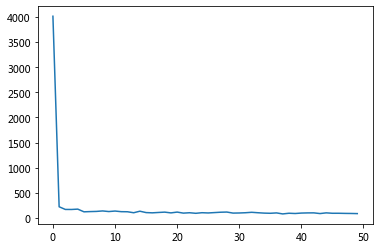

In [9]:
plt.plot(range(len(losses)), losses)

In [10]:
W2.value

array([[ 6.39773912],
       [ 8.68640726],
       [10.96728665],
       [ 5.47055828],
       [ 4.56155794],
       [ 6.1204663 ],
       [15.01999148],
       [ 9.12138544],
       [ 6.95899867],
       [ 5.36676779]])

In [11]:
X_ = data['data']

In [12]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [13]:
import keras

Using TensorFlow backend.


In [14]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [15]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
             optimizer='sgd',
             metrics=['mse'])

In [16]:
model.fit(X_, y_, epochs=500, batch_size=32)

Epoch 1/500
506/506 [==============================] - 0s 174us/step - loss: 137.5793 - mse: 137.5793
Epoch 2/500
506/506 [==============================] - 0s 33us/step - loss: 79.3503 - mse: 79.3503
Epoch 3/500
506/506 [==============================] - 0s 35us/step - loss: 76.3735 - mse: 76.3735
Epoch 4/500
506/506 [==============================] - 0s 67us/step - loss: 84.5858 - mse: 84.5858
Epoch 5/500
506/506 [==============================] - 0s 46us/step - loss: 81.3073 - mse: 81.3073
Epoch 6/500
506/506 [==============================] - 0s 56us/step - loss: 79.8389 - mse: 79.8389
Epoch 7/500
506/506 [==============================] - 0s 50us/step - loss: 78.1089 - mse: 78.1089
Epoch 8/500
506/506 [==============================] - 0s 36us/step - loss: 76.5594 - mse: 76.5594
Epoch 9/500
506/506 [==============================] - 0s 60us/step - loss: 80.5075 - mse: 80.5075
Epoch 10/500
506/506 [==============================] - 0s 48us/step - loss: 83.3327 - mse: 83.3327
Epoch 

Epoch 83/500
506/506 [==============================] - 0s 48us/step - loss: 78.8497 - mse: 78.8497
Epoch 84/500
506/506 [==============================] - 0s 46us/step - loss: 78.6956 - mse: 78.6956
Epoch 85/500
506/506 [==============================] - 0s 42us/step - loss: 78.1895 - mse: 78.1895
Epoch 86/500
506/506 [==============================] - 0s 46us/step - loss: 77.9768 - mse: 77.9768
Epoch 87/500
506/506 [==============================] - 0s 46us/step - loss: 78.4666 - mse: 78.4666
Epoch 88/500
506/506 [==============================] - 0s 39us/step - loss: 77.7905 - mse: 77.7905
Epoch 89/500
506/506 [==============================] - 0s 43us/step - loss: 78.0713 - mse: 78.0713
Epoch 90/500
506/506 [==============================] - 0s 45us/step - loss: 78.3565 - mse: 78.3565
Epoch 91/500
506/506 [==============================] - 0s 46us/step - loss: 78.4405 - mse: 78.4405
Epoch 92/500
506/506 [==============================] - 0s 37us/step - loss: 78.7508 - mse: 78.7508


506/506 [==============================] - 0s 36us/step - loss: 77.9080 - mse: 77.9080
Epoch 165/500
506/506 [==============================] - 0s 42us/step - loss: 77.9324 - mse: 77.9324
Epoch 166/500
506/506 [==============================] - 0s 37us/step - loss: 78.3023 - mse: 78.3023
Epoch 167/500
506/506 [==============================] - 0s 54us/step - loss: 78.0335 - mse: 78.0335
Epoch 168/500
506/506 [==============================] - 0s 45us/step - loss: 77.6322 - mse: 77.6322
Epoch 169/500
506/506 [==============================] - 0s 47us/step - loss: 77.9729 - mse: 77.9729
Epoch 170/500
506/506 [==============================] - 0s 33us/step - loss: 77.7129 - mse: 77.7129
Epoch 171/500
506/506 [==============================] - 0s 47us/step - loss: 78.7010 - mse: 78.7010
Epoch 172/500
506/506 [==============================] - 0s 35us/step - loss: 78.4562 - mse: 78.4562
Epoch 173/500
506/506 [==============================] - 0s 47us/step - loss: 78.0116 - mse: 78.0116
Epoc

506/506 [==============================] - 0s 59us/step - loss: 77.4202 - mse: 77.4202
Epoch 246/500
506/506 [==============================] - 0s 57us/step - loss: 79.1963 - mse: 79.1964
Epoch 247/500
506/506 [==============================] - 0s 42us/step - loss: 77.3099 - mse: 77.3099
Epoch 248/500
506/506 [==============================] - 0s 34us/step - loss: 77.9218 - mse: 77.9218
Epoch 249/500
506/506 [==============================] - 0s 44us/step - loss: 78.3089 - mse: 78.3088
Epoch 250/500
506/506 [==============================] - 0s 35us/step - loss: 78.0953 - mse: 78.0953
Epoch 251/500
506/506 [==============================] - 0s 37us/step - loss: 78.0532 - mse: 78.0532
Epoch 252/500
506/506 [==============================] - 0s 42us/step - loss: 78.1516 - mse: 78.1516
Epoch 253/500
506/506 [==============================] - 0s 51us/step - loss: 77.8851 - mse: 77.8851
Epoch 254/500
506/506 [==============================] - 0s 49us/step - loss: 78.5558 - mse: 78.5558
Epoc

506/506 [==============================] - 0s 41us/step - loss: 77.7870 - mse: 77.7870
Epoch 326/500
506/506 [==============================] - 0s 55us/step - loss: 78.4368 - mse: 78.4368
Epoch 327/500
506/506 [==============================] - 0s 56us/step - loss: 78.4891 - mse: 78.4891
Epoch 328/500
506/506 [==============================] - 0s 34us/step - loss: 78.1845 - mse: 78.1845
Epoch 329/500
506/506 [==============================] - 0s 40us/step - loss: 78.7895 - mse: 78.7895
Epoch 330/500
506/506 [==============================] - 0s 49us/step - loss: 78.3880 - mse: 78.3880
Epoch 331/500
506/506 [==============================] - 0s 34us/step - loss: 78.0340 - mse: 78.0340
Epoch 332/500
506/506 [==============================] - 0s 38us/step - loss: 77.9838 - mse: 77.9838
Epoch 333/500
506/506 [==============================] - 0s 30us/step - loss: 78.4252 - mse: 78.4252
Epoch 334/500
506/506 [==============================] - 0s 26us/step - loss: 77.8329 - mse: 77.8329
Epoc

506/506 [==============================] - 0s 58us/step - loss: 78.5278 - mse: 78.5278
Epoch 407/500
506/506 [==============================] - 0s 50us/step - loss: 77.5729 - mse: 77.5729
Epoch 408/500
506/506 [==============================] - 0s 52us/step - loss: 77.8587 - mse: 77.8587
Epoch 409/500
506/506 [==============================] - 0s 44us/step - loss: 78.3681 - mse: 78.3681
Epoch 410/500
506/506 [==============================] - 0s 42us/step - loss: 78.0216 - mse: 78.0216
Epoch 411/500
506/506 [==============================] - 0s 51us/step - loss: 78.3620 - mse: 78.3620
Epoch 412/500
506/506 [==============================] - 0s 46us/step - loss: 78.2448 - mse: 78.2448
Epoch 413/500
506/506 [==============================] - 0s 49us/step - loss: 77.7516 - mse: 77.7516
Epoch 414/500
506/506 [==============================] - 0s 43us/step - loss: 78.0363 - mse: 78.0363
Epoch 415/500
506/506 [==============================] - 0s 38us/step - loss: 78.0755 - mse: 78.0755
Epoc

506/506 [==============================] - 0s 34us/step - loss: 78.2962 - mse: 78.2962
Epoch 488/500
506/506 [==============================] - 0s 50us/step - loss: 77.8605 - mse: 77.8605
Epoch 489/500
506/506 [==============================] - 0s 42us/step - loss: 78.3232 - mse: 78.3232
Epoch 490/500
506/506 [==============================] - 0s 33us/step - loss: 77.8706 - mse: 77.8706
Epoch 491/500
506/506 [==============================] - 0s 38us/step - loss: 77.9078 - mse: 77.9078
Epoch 492/500
506/506 [==============================] - 0s 33us/step - loss: 78.1467 - mse: 78.1467
Epoch 493/500
506/506 [==============================] - 0s 35us/step - loss: 77.9057 - mse: 77.9057
Epoch 494/500
506/506 [==============================] - 0s 40us/step - loss: 77.6487 - mse: 77.6487
Epoch 495/500
506/506 [==============================] - 0s 43us/step - loss: 78.1703 - mse: 78.1703
Epoch 496/500
506/506 [==============================] - 0s 42us/step - loss: 77.7541 - mse: 77.7541
Epoc

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

A function that can produce predictions.
>+ z = w^T*x+b
+ y_hat = sigmoid(z) = 1 / (1 + e^(-z))

####  2. Why we use non-linear activation funcitons in neural networks?

The purpose is to introduce non-linearity to the neural network. One of the reasons is to produce better performance where linear function cannot simulate non-linear situation, and this can be done using explanatory variables.

#### 3. What is the 'Logistic Loss' ?

Also called log loss,
$$ L = -y*log(y') - (1-y)log(y')$$
It is the price that logistic function(regression) paid for inaccuracy of the function

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C (sigmoid [0,1])
Note. tanh [-1, 1]
Relu [0,+inf]

#### 5. Why we don't use zero initialization for all parameters ?

Disregard b's which may be zero, and focus on weight (w). The first reason is that if weights are initialised to zeros then every hidden unit will be zero regardless of the input. The second reason is that such error will be backpropagated through and cause symmetry problems (because all weights are updated with the same value).

#### 6. Can you implement the softmax function using python ? 

$$ softmax = \frac{e^{a_i}}{\sum_{j}(e^{a_j})} $$

In [17]:
import numpy as np
def softmax(a):
    return np.exp(a)/np.sum(np.exp(a))
softmax([1,2,3,4])

array([0.0320586 , 0.08714432, 0.23688282, 0.64391426])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [18]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [19]:
# Loading the data 
digits = datasets.load_digits()

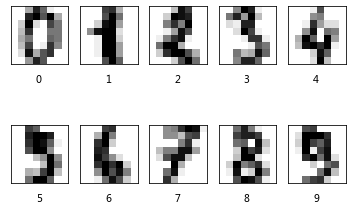

In [20]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [21]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [22]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [25]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1 / (1 + np.exp(-z))
    
    return s

In [26]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [27]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.randn(dim,1)
    b = np.random.randn()
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [51]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    
    # forward propagation
    A = sigmoid(np.dot(w.T, X) + b) # activation
    cost = -(np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))) / m

    # backpropagation to find gradients
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [52]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [53]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [54]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # initialise parameters
    w, b = initialize_parameters(X_train.shape[0])
    
    # train the model
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    
    # training accuracy
    Y_train_hat = predict(w, b, X_train)
    training_accuracy = np.mean(Y_train_hat == Y_train)
    
    # test accuracy
    Y_hat = predict(w, b, X_test)
    test_accuracy = np.mean(Y_test == Y_hat)
    
    d = {"w":w,
         "b":b,
         "training_accuracy":training_accuracy,
         "test_accuracy":test_accuracy,
         "cost":cost
        }
    return d

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [55]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [56]:
num_iterations = 30000
learning_rate = 1e-2
d = model(X_train.T, y_train, X_test.T, y_test, num_iterations, learning_rate, True)

/Users/zhiweihuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/zhiweihuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


Cost after iteration 0: nan
Cost after iteration 1000: nan
Cost after iteration 2000: nan
Cost after iteration 3000: nan
Cost after iteration 4000: nan
Cost after iteration 5000: nan
Cost after iteration 6000: nan
Cost after iteration 7000: nan
Cost after iteration 8000: nan
Cost after iteration 9000: nan
Cost after iteration 10000: nan
Cost after iteration 11000: nan
Cost after iteration 12000: nan
Cost after iteration 13000: nan
Cost after iteration 14000: nan
Cost after iteration 15000: nan
Cost after iteration 16000: nan
Cost after iteration 17000: nan
Cost after iteration 18000: nan
Cost after iteration 19000: nan
Cost after iteration 20000: nan
Cost after iteration 21000: nan
Cost after iteration 22000: nan
Cost after iteration 23000: nan
Cost after iteration 24000: nan
Cost after iteration 25000: nan
Cost after iteration 26000: nan
Cost after iteration 27000: nan
Cost after iteration 28000: nan
Cost after iteration 29000: nan


##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 